In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model ,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Activation , BatchNormalization
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import VGG19 , ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.metrics import  classification_report

In [2]:
file_path = '../input/plantdisease/PlantVillage/'


In [3]:
name_class = os.listdir(file_path)
name_class

['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']

In [4]:
filepaths = list(glob.glob(file_path+'/**/*.*'))
image_counts={}
for c in name_class:
    path=file_path+c
    count=len(os.listdir(path))
    image_counts[c]=count

df = pd.DataFrame.from_dict(image_counts,orient='index')
df


,0
Pepper__bell___Bacterial_spot,997
Potato___healthy,152
Tomato_Leaf_Mold,952
Tomato__Tomato_YellowLeaf__Curl_Virus,3209
Tomato_Bacterial_spot,2127
Tomato_Septoria_leaf_spot,1771
Tomato_healthy,1591
Tomato_Spider_mites_Two_spotted_spider_mite,1676
Tomato_Early_blight,1000
Tomato__Target_Spot,1404


In [5]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Filepath,Label
0,../input/plantdisease/PlantVillage/Tomato_Bact...,Tomato_Bacterial_spot
1,../input/plantdisease/PlantVillage/Potato___La...,Potato___Late_blight
2,../input/plantdisease/PlantVillage/Tomato_Late...,Tomato_Late_blight
3,../input/plantdisease/PlantVillage/Tomato__Tom...,Tomato__Tomato_YellowLeaf__Curl_Virus
4,../input/plantdisease/PlantVillage/Pepper__bel...,Pepper__bell___Bacterial_spot


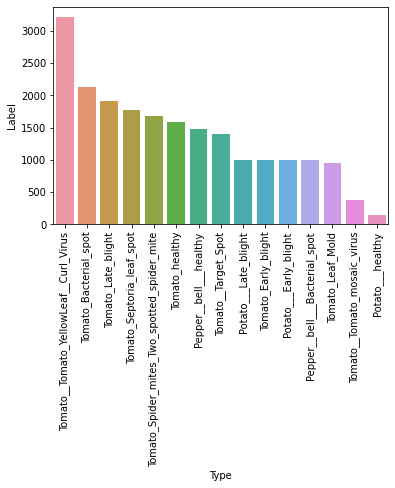

In [6]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [7]:
train, test = train_test_split(data, test_size=0.25, random_state=42)


In [8]:
# Shape of the Image
from PIL import Image
img = Image.open(data.Filepath[1])
arr=np.array(img)
arr.shape

(256, 256, 3)

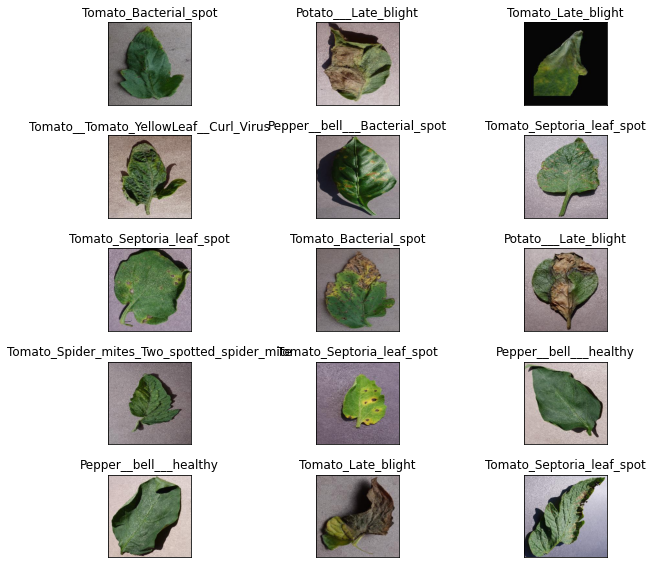

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12383 validated image filenames belonging to 15 classes.
Found 3095 validated image filenames belonging to 15 classes.
Found 5160 validated image filenames belonging to 15 classes.


# **AlexNet : Pretrained Model**

In [12]:
Alexnet=Sequential()

Alexnet.add(Conv2D(96,input_shape=(100,100,3),kernel_size=(11,11),strides=(4,4),padding='valid'))
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('relu'))
Alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))   


Alexnet.add(Conv2D(256,kernel_size=(5,5),strides=(1,1),padding='same'))
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('relu'))
Alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))

Alexnet.add(Conv2D(384,kernel_size=(3,3),strides=(1,1),padding='same'))
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('relu'))

Alexnet.add(Conv2D(384,kernel_size=(3,3),strides=(1,1),padding='same'))
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('relu')) 

Alexnet.add(Conv2D(256,kernel_size=(3,3),strides=(1,1),padding='same'))
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('relu'))
Alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))

Alexnet.add(Flatten())
Alexnet.add(Dense(4096,input_shape=(100,100,3,)))   
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('relu'))
Alexnet.add(Dropout(0.4))

Alexnet.add(Dense(4096))
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('relu'))
Alexnet.add(Dropout(0.4))

Alexnet.add(Dense(1000))
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('relu'))
Alexnet.add(Dropout(0.4))

Alexnet.add(Dense(15))
Alexnet.add(BatchNormalization())
Alexnet.add(Activation('softmax'))


2022-03-08 02:50:58.119491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 02:50:58.216422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 02:50:58.217212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 02:50:58.218534: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
Alexnet.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [14]:
AlexNet_history=Alexnet.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

2022-03-08 02:51:01.459984: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-08 02:51:03.920699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


387/387 [==============================] - 101s 242ms/step - loss: 1.3748 - accuracy: 0.6079 - val_loss: 2.3018 - val_accuracy: 0.4468
Epoch 2/10
387/387 [==============================] - 32s 83ms/step - loss: 0.9126 - accuracy: 0.7424 - val_loss: 0.7111 - val_accuracy: 0.7919
Epoch 3/10
387/387 [==============================] - 32s 82ms/step - loss: 0.7294 - accuracy: 0.7963 - val_loss: 1.4570 - val_accuracy: 0.5774
Epoch 4/10
387/387 [==============================] - 32s 82ms/step - loss: 0.6018 - accuracy: 0.8342 - val_loss: 0.5210 - val_accuracy: 0.8498
Epoch 5/10
387/387 [==============================] - 32s 83ms/step - loss: 0.5127 - accuracy: 0.8596 - val_loss: 0.4218 - val_accuracy: 0.8698
Epoch 6/10
387/387 [==============================] - 32s 83ms/step - loss: 0.4333 - accuracy: 0.8837 - val_loss: 0.4246 - val_accuracy: 0.8756
Epoch 7/10
387/387 [==============================] - 32s 83ms/step - loss: 0.3871 - accuracy: 0.8948 - val_loss: 0.5643 - val_accuracy: 0.8355
E

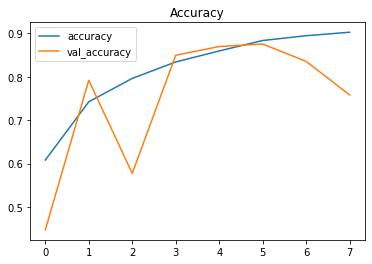

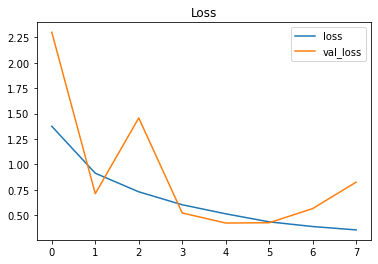

In [15]:
pd.DataFrame(AlexNet_history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(AlexNet_history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [16]:
alex_results = Alexnet.evaluate(test_gen, verbose=0)

print("Test Accuracy: {:.2f}%".format(alex_results[1] * 100))

Test Accuracy: 75.64%


In [17]:
#results = Alexnet.evaluate(test_gen, verbose=0)

In [18]:
# Predict the label of the test_gen
pred = Alexnet.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [19]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.72      0.77       245
                     Pepper__bell___healthy       0.98      0.73      0.84       385
                      Potato___Early_blight       1.00      0.81      0.89       250
                       Potato___Late_blight       0.75      0.92      0.83       256
                           Potato___healthy       0.77      0.70      0.73        43
                      Tomato_Bacterial_spot       0.98      0.77      0.86       556
                        Tomato_Early_blight       0.59      0.68      0.63       237
                         Tomato_Late_blight       0.80      0.81      0.81       457
                           Tomato_Leaf_Mold       0.81      0.53      0.64       222
                  Tomato_Septoria_leaf_spot       0.38      0.99      0.55       446
Tomato_Spider_mites_Two_spotted_spider_mite       0.98      0.47

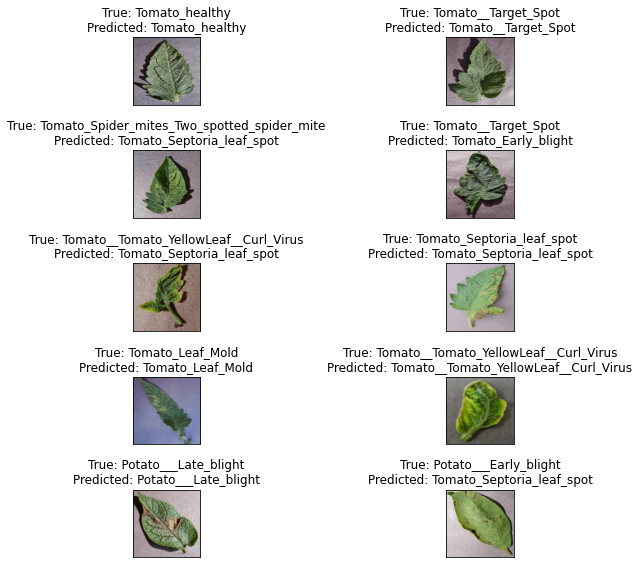

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# **VGG19 : Pretrained Model**

In [21]:
vgg_model = VGG19(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

80150528/80134624 [==============================] - 1s 0us/step


In [22]:
inputs = vgg_model.input

x = Dense(128, activation='relu')(vgg_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(15, activation='softmax')(x)

vgg19_model = Model(inputs=inputs, outputs=outputs)

In [23]:
vgg19_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]


In [25]:
vgg19_history = vgg19_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

Epoch 1/10
387/387 [==============================] - 43s 106ms/step - loss: 2.4303 - accuracy: 0.2400 - val_loss: 1.9573 - val_accuracy: 0.3192
Epoch 2/10
387/387 [==============================] - 39s 102ms/step - loss: 1.8683 - accuracy: 0.3735 - val_loss: 1.6231 - val_accuracy: 0.4553
Epoch 3/10
387/387 [==============================] - 39s 100ms/step - loss: 1.5309 - accuracy: 0.4836 - val_loss: 1.3386 - val_accuracy: 0.5493
Epoch 4/10
387/387 [==============================] - 39s 102ms/step - loss: 1.3333 - accuracy: 0.5493 - val_loss: 1.4887 - val_accuracy: 0.5015
Epoch 5/10
387/387 [==============================] - 42s 108ms/step - loss: 1.1069 - accuracy: 0.6230 - val_loss: 1.0347 - val_accuracy: 0.6533
Epoch 6/10
387/387 [==============================] - 41s 105ms/step - loss: 0.9148 - accuracy: 0.6900 - val_loss: 0.9449 - val_accuracy: 0.6850
Epoch 7/10
387/387 [==============================] - 40s 104ms/step - loss: 0.7765 - accuracy: 0.7388 - val_loss: 0.7607 - val_ac

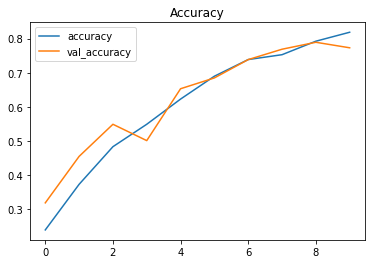

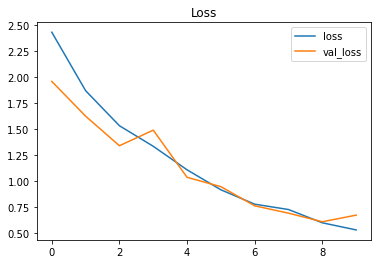

In [26]:
pd.DataFrame(vgg19_history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(vgg19_history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [27]:
vgg19_loss,vgg19_accuracy= vgg19_model.evaluate(test_gen, verbose=0)
print("Test Accuracy: {:.2f}%".format(vgg19_accuracy * 100))

Test Accuracy: 78.16%


In [28]:
# Predict the label of the test_gen
pred = vgg19_model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [29]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.64      0.72       245
                     Pepper__bell___healthy       0.90      0.89      0.89       385
                      Potato___Early_blight       0.90      0.89      0.89       250
                       Potato___Late_blight       0.63      0.36      0.46       256
                           Potato___healthy       0.68      0.35      0.46        43
                      Tomato_Bacterial_spot       0.87      0.90      0.89       556
                        Tomato_Early_blight       0.57      0.49      0.53       237
                         Tomato_Late_blight       0.58      0.86      0.69       457
                           Tomato_Leaf_Mold       0.84      0.61      0.71       222
                  Tomato_Septoria_leaf_spot       0.83      0.58      0.69       446
Tomato_Spider_mites_Two_spotted_spider_mite       0.58      0.98

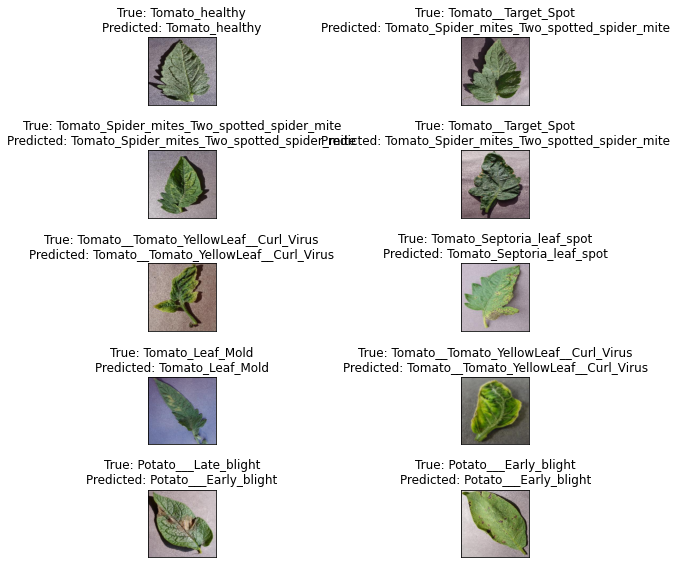

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# **Google Net : Pretrained Model**

In [31]:
from keras.layers import GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

In [32]:
base_model=InceptionV3(input_shape=(100,100,3),include_top=False,weights='imagenet')
N_Class=15
x=base_model.output
x=GlobalAveragePooling2D()(x)


87924736/87910968 [==============================] - 1s 0us/step


In [33]:
for layer in base_model.layers:
    layer.trainable=False

In [34]:
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.25)(x)
predictions=Dense(N_Class,activation='softmax')(x)
google_net=Model(base_model.input,predictions)


In [35]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [36]:
google_net.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=google_net.fit(train_gen,validation_data=valid_gen,epochs=10,callbacks=my_callbacks)

Epoch 1/10
387/387 [==============================] - 42s 99ms/step - loss: 4.5554 - accuracy: 0.2063 - val_loss: 2.3543 - val_accuracy: 0.2414
Epoch 2/10
387/387 [==============================] - 37s 94ms/step - loss: 2.3254 - accuracy: 0.2509 - val_loss: 2.1909 - val_accuracy: 0.3021
Epoch 3/10
387/387 [==============================] - 37s 95ms/step - loss: 2.2461 - accuracy: 0.2654 - val_loss: 2.1284 - val_accuracy: 0.3150
Epoch 4/10
387/387 [==============================] - 37s 95ms/step - loss: 2.1773 - accuracy: 0.2814 - val_loss: 2.0715 - val_accuracy: 0.3396
Epoch 5/10
387/387 [==============================] - 37s 95ms/step - loss: 2.1551 - accuracy: 0.2919 - val_loss: 2.1211 - val_accuracy: 0.3179
Epoch 6/10
387/387 [==============================] - 38s 97ms/step - loss: 2.1091 - accuracy: 0.3068 - val_loss: 2.0043 - val_accuracy: 0.3557
Epoch 7/10
387/387 [==============================] - 38s 97ms/step - loss: 2.0660 - accuracy: 0.3160 - val_loss: 2.0316 - val_accuracy:

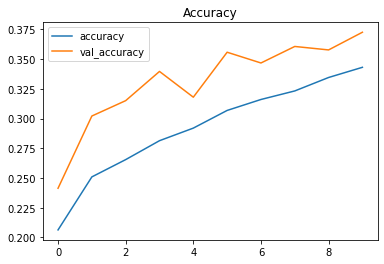

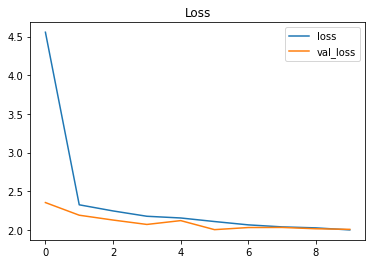

In [37]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [38]:
google_net_loss,google_net_accuracy = google_net.evaluate(test_gen, verbose=0)
print("Test Accuracy: {:.2f}%".format(google_net_accuracy * 100))

Test Accuracy: 36.49%


In [39]:
# Predict the label of the test_gen
pred = google_net.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [40]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00       245
                     Pepper__bell___healthy       0.37      0.39      0.38       385
                      Potato___Early_blight       0.50      0.24      0.32       250
                       Potato___Late_blight       0.00      0.00      0.00       256
                           Potato___healthy       0.00      0.00      0.00        43
                      Tomato_Bacterial_spot       0.69      0.45      0.55       556
                        Tomato_Early_blight       0.00      0.00      0.00       237
                         Tomato_Late_blight       0.26      0.46      0.33       457
                           Tomato_Leaf_Mold       0.32      0.50      0.39       222
                  Tomato_Septoria_leaf_spot       0.22      0.15      0.18       446
Tomato_Spider_mites_Two_spotted_spider_mite       0.18      0.27

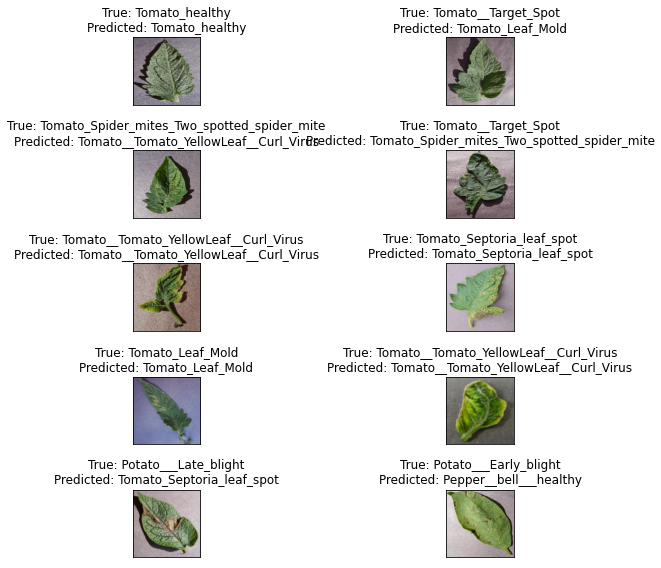

In [41]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# **ResNet : Pretrained Model**

In [42]:
base_model=ResNet50(input_shape=(100,100,3),include_top=False,weights='imagenet')

for layer in base_model.layers:
      layer.trainable=False

94781440/94765736 [==============================] - 0s 0us/step


In [43]:
x=base_model.output
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(15,activation='softmax')(x)
resnet=Model(base_model.input,x)

In [44]:
resnet.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [45]:
resnet_history=resnet.fit(train_gen,validation_data=valid_gen,epochs=5,callbacks=my_callbacks)

Epoch 1/5
387/387 [==============================] - 42s 100ms/step - loss: 1.5808 - accuracy: 0.7598 - val_loss: 0.4334 - val_accuracy: 0.8494
Epoch 2/5
387/387 [==============================] - 37s 97ms/step - loss: 0.3461 - accuracy: 0.8907 - val_loss: 0.3655 - val_accuracy: 0.8824
Epoch 3/5
387/387 [==============================] - 36s 92ms/step - loss: 0.2746 - accuracy: 0.9091 - val_loss: 0.3349 - val_accuracy: 0.9066
Epoch 4/5
387/387 [==============================] - 38s 98ms/step - loss: 0.2103 - accuracy: 0.9285 - val_loss: 0.3056 - val_accuracy: 0.9102
Epoch 5/5
387/387 [==============================] - 36s 92ms/step - loss: 0.1664 - accuracy: 0.9451 - val_loss: 0.3459 - val_accuracy: 0.9137


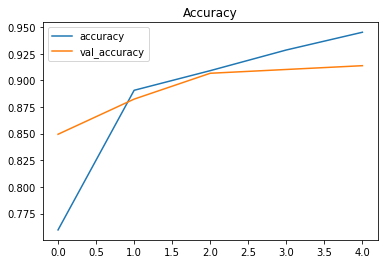

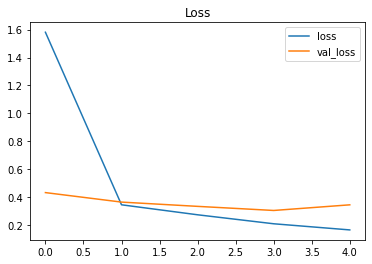

In [46]:
pd.DataFrame(resnet_history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(resnet_history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [47]:
resnet_results =resnet.evaluate(test_gen, verbose=0)

print("Test Accuracy: {:.2f}%".format(resnet_results[1] * 100))

Test Accuracy: 91.30%


In [48]:
# Predict the label of the test_gen
pred = resnet.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [49]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.93      0.95       245
                     Pepper__bell___healthy       0.98      0.95      0.96       385
                      Potato___Early_blight       0.99      0.91      0.95       250
                       Potato___Late_blight       0.81      0.98      0.89       256
                           Potato___healthy       0.72      0.79      0.76        43
                      Tomato_Bacterial_spot       0.94      0.96      0.95       556
                        Tomato_Early_blight       0.77      0.81      0.79       237
                         Tomato_Late_blight       0.94      0.84      0.89       457
                           Tomato_Leaf_Mold       0.99      0.64      0.78       222
                  Tomato_Septoria_leaf_spot       0.83      0.92      0.87       446
Tomato_Spider_mites_Two_spotted_spider_mite       0.87      0.91

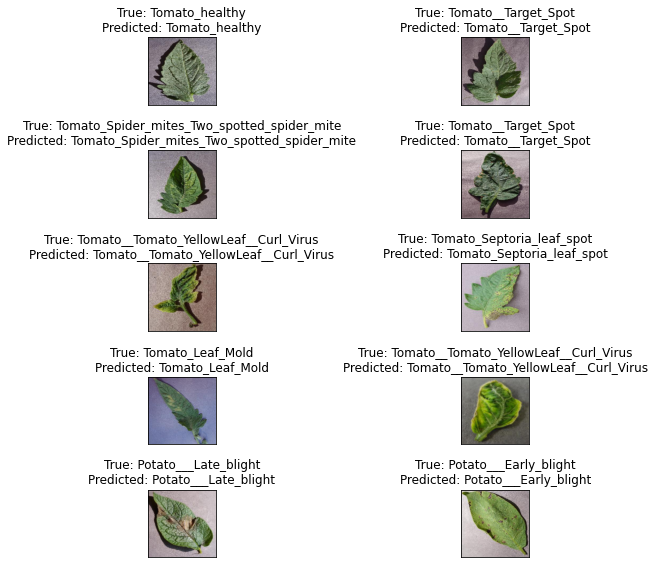

In [50]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# **Custom Model**

In [51]:
EPOCHS = 25
BS = 32

In [52]:
n_classes = 15
custom_model = Sequential()
custom_model.add(Conv2D(32, (3, 3), padding="same",input_shape=(100,100,3)))
custom_model.add(Activation("relu"))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(3, 3)))
custom_model.add(Dropout(0.25))
custom_model.add(Conv2D(64, (3, 3), padding="same"))
custom_model.add(Activation("relu"))
custom_model.add(BatchNormalization())
custom_model.add(Conv2D(64, (3, 3), padding="same"))
custom_model.add(Activation("relu"))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))
custom_model.add(Conv2D(128, (3, 3), padding="same"))
custom_model.add(Activation("relu"))
custom_model.add(BatchNormalization())
custom_model.add(Conv2D(128, (3, 3), padding="same"))
custom_model.add(Activation("relu"))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))
custom_model.add(Flatten())
custom_model.add(Dense(1024))
custom_model.add(Activation("relu"))
custom_model.add(BatchNormalization())
custom_model.add(Dropout(0.5))
custom_model.add(Dense(n_classes))
custom_model.add(Activation("softmax"))


In [53]:
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_103 (Activation)  (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 33, 33, 64)        18496     
_________________________________________________________________
activation_104 (Activation)  (None, 33, 33, 64)       

In [54]:
custom_model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

In [55]:
history = custom_model.fit(train_gen,
    validation_data=valid_gen,
    steps_per_epoch=32,
    epochs=20, verbose=1
    )

Epoch 1/20
32/32 [==============================] - 11s 295ms/step - loss: 2.3788 - accuracy: 0.3965 - val_loss: 12.5472 - val_accuracy: 0.1431
Epoch 2/20
32/32 [==============================] - 8s 262ms/step - loss: 1.4004 - accuracy: 0.5801 - val_loss: 4.6655 - val_accuracy: 0.3438
Epoch 3/20
32/32 [==============================] - 9s 277ms/step - loss: 1.1323 - accuracy: 0.6582 - val_loss: 3.4517 - val_accuracy: 0.3725
Epoch 4/20
32/32 [==============================] - 9s 273ms/step - loss: 1.0082 - accuracy: 0.6914 - val_loss: 2.0196 - val_accuracy: 0.5554
Epoch 5/20
32/32 [==============================] - 8s 271ms/step - loss: 0.9082 - accuracy: 0.7129 - val_loss: 1.3508 - val_accuracy: 0.6452
Epoch 6/20
32/32 [==============================] - 9s 276ms/step - loss: 0.8189 - accuracy: 0.7373 - val_loss: 1.7826 - val_accuracy: 0.6084
Epoch 7/20
32/32 [==============================] - 11s 345ms/step - loss: 0.7716 - accuracy: 0.7517 - val_loss: 1.0466 - val_accuracy: 0.7312
Epo

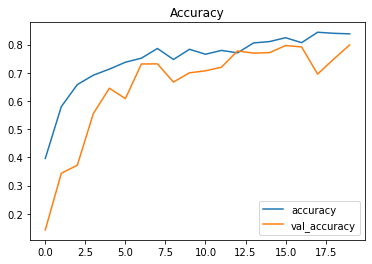

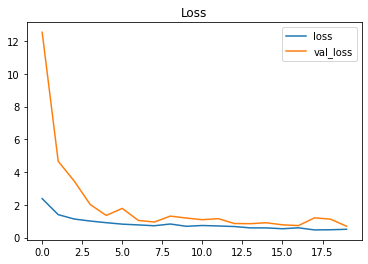

In [56]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [57]:
custom_results =custom_model.evaluate(test_gen, verbose=0)

print("Test Accuracy: {:.2f}%".format(custom_results[1] * 100))

Test Accuracy: 80.12%


In [58]:
pred = custom_model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [59]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.57      0.72      0.64       245
                     Pepper__bell___healthy       0.96      0.57      0.72       385
                      Potato___Early_blight       0.92      0.75      0.83       250
                       Potato___Late_blight       0.68      0.74      0.71       256
                           Potato___healthy       0.73      0.56      0.63        43
                      Tomato_Bacterial_spot       0.94      0.92      0.93       556
                        Tomato_Early_blight       0.77      0.55      0.64       237
                         Tomato_Late_blight       0.78      0.69      0.73       457
                           Tomato_Leaf_Mold       0.88      0.74      0.80       222
                  Tomato_Septoria_leaf_spot       0.69      0.78      0.73       446
Tomato_Spider_mites_Two_spotted_spider_mite       0.91      0.72

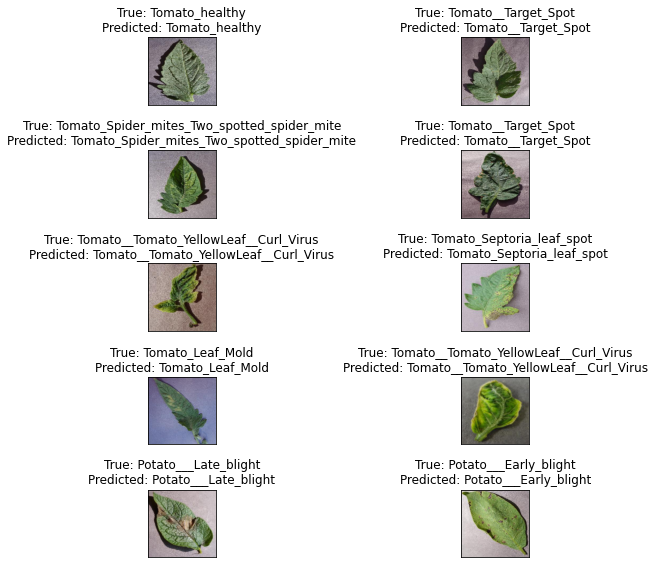

In [60]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# **Comparing Accuracies and Loss between Implemented Models**

In [61]:
import matplotlib.pyplot as plt

li=['Alex_Net','VGG_19','Goog_Net','Res_Net','Custom_Model']

alexnet=f'{alex_results[1]:.2f}'
googlenet=f'{google_net_accuracy:.2f}'
resnet=f'{resnet_results[1]:.2f}'
vgg19=f'{vgg19_accuracy:.2f}'
custom=f'{custom_results[1]:.2f}'

acc=[alexnet,vgg19,googlenet,resnet,custom]

c = ['red', 'yellow', 'black', 'blue', 'orange']

df=pd.DataFrame(
    {'Model':li,'Model Accuracy':acc})
df.index = [1,2,3,4,5]
df

,Model,Model Accuracy
1,Alex_Net,0.76
2,VGG_19,0.78
3,Goog_Net,0.36
4,Res_Net,0.91
5,Custom_Model,0.80


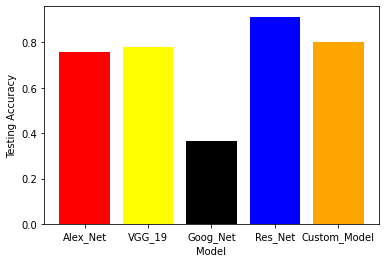

In [62]:
import matplotlib.pyplot as plt

li=['Alex_Net','VGG_19','Goog_Net','Res_Net','Custom_Model']

alexnet=f'{alex_results[1]:.2f}'
googlenet=f'{google_net_accuracy:.2f}'
resnet=f'{resnet_results[1]:.2f}'
vgg19=f'{vgg19_accuracy:.2f}'
custom=f'{custom_results[1]:.2f}'

acc=[alex_results[1],vgg19_accuracy,google_net_accuracy,resnet_results[1],custom_results[1]]


c = ['red', 'yellow', 'black', 'blue', 'orange']

line=plt.bar(li,height=acc,color=c,)

plt.xlabel('Model')
plt.ylabel('Testing Accuracy')


plt.show()

In [63]:
import matplotlib.pyplot as plt

li=['Alex_Net','VGG_19','Goog_Net','Res_Net','Custom_Model']

alexnet=f'{alex_results[0]:.2f}'
googlenet=f'{google_net_loss:.2f}'
resnet=f'{resnet_results[0]:.2f}'
vgg19=f'{vgg19_loss:.2f}'
custom=f'{custom_results[0]:.2f}'

acc=[alexnet,vgg19,googlenet,resnet,custom]

c = ['red', 'yellow', 'black', 'blue', 'orange']

df=pd.DataFrame(
    {'Model':li,'Model Loss':acc})
df.index = [1,2,3,4,5]
df

,Model,Model Loss
1,Alex_Net,0.83
2,VGG_19,0.65
3,Goog_Net,1.98
4,Res_Net,0.34
5,Custom_Model,0.70


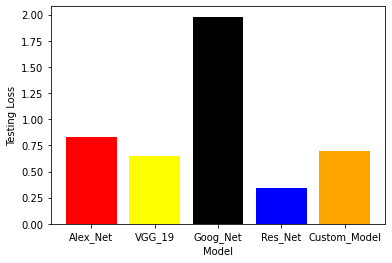

In [64]:
import matplotlib.pyplot as plt

li=['Alex_Net','VGG_19','Goog_Net','Res_Net','Custom_Model']

alexnet=f'{alex_results[1]:.2f}'
googlenet=f'{google_net_accuracy:.2f}'
resnet=f'{resnet_results[1]:.2f}'
vgg19=f'{vgg19_accuracy:.2f}'
custom=f'{custom_results[1]:.2f}'

acc=[alex_results[0],vgg19_loss,google_net_loss,resnet_results[0],custom_results[0]]


c = ['red', 'yellow', 'black', 'blue', 'orange']

line=plt.bar(li,height=acc,color=c,)

plt.xlabel('Model')
plt.ylabel('Testing Loss')


plt.show()

In [65]:
resnet.save('resnet_model.h5')

AttributeError: 'str' object has no attribute 'save'